# M2177.003100 Deep Learning <br> Assignment #4 Implementing Conditional Generative Adversarial Nets - part2 MNIST data

Copyright (C) Data Science Laboratory, Seoul National University. This material is for educational uses only. Some contents are based on the material provided by other paper/book authors and may be copyrighted by them. Written by Jaeyoon Yoo, November 2017

In this notebook, you will learn how to implement conditional Genverative Adversarial Nets (cGANs) <br>
The goal here is to build GANs that draw a digit(MNIST data) given its label. <br> 

**Note**: certain details are missing or ambiguous on purpose, in order to test your knowledge on the related materials. However, if you really feel that something essential is missing and cannot proceed to the next step, then contact the teaching staff with clear description of your problem.

### Submitting your work:
<font color=red>**DO NOT clear the final outputs**</font> so that TAs can grade both your code and results.  
Once you have done **all parts**, run the *CollectSubmission.sh* script with your **Team number** as input argument. <br>
This will produce a zipped file called *[Your team number].zip*. Please submit this file on ETL. &nbsp;&nbsp; (Usage: ./*CollectSubmission.sh* &nbsp; Team_#)

### Some helpful tutorials and references for assignment #2:
- [1] TensorFlow official tutorials. [[link]](https://www.tensorflow.org/get_started/get_started)
- [2] Stanford CS231n lectures. [[link]](http://cs231n.stanford.edu/)
- [3] Goodfellow, Ian, et al. "Generative adversarial nets." Advances in neural information processing systems. 2014.
- [4] Mirza, Mehdi, and Simon Osindero. "Conditional generative adversarial nets." arXiv preprint arXiv:1411.1784 (2014).
- [5] Radford, Alec, Luke Metz, and Soumith Chintala. "Unsupervised representation learning with deep convolutional generative adversarial networks." arXiv preprint arXiv:1511.06434 (2015).

## 0. Download and load MNIST datasets
The MNIST datasets will be downloaded into the 'data' directory. If you want to change the directory the data is saved in, change mnist_data_dir with where you want. <br>

In [6]:
from download import *
import os
from utils import load_mnist
mnist_data_dir = './data'
prepare_data_dir(mnist_data_dir)
download_mnist(mnist_data_dir)
data_array , data_y = load_mnist(os.path.join(mnist_data_dir,'mnist'))
print(data_array.shape)
print(data_y.shape)

Found MNIST - skip
(70000, 28, 28, 1)
(70000, 10)


## <a name="1"></a> 1. Build a network

In this section, you will implement neural networks for (1) generative model to draw a digit (2) discriminative model to distinguish real image from generated image. You can use some function in *ops.py* or you can make it as you want. Just write the code in whatever way you find most clear.

In [7]:
from ops import conv2d
from ops import lrelu
from ops import de_conv
from ops import fully_connect
from ops import conv_cond_concat
from ops import batch_normal

import tensorflow as tf
import numpy as np

It is time for a generative model. It takes batch size, sample size(the dimension of latent variable or so called *noise*), y_dim(the dimension of label), the output size(should be 28 here) and z,y (Tensorflow Variables for latent variable and label respectively). It should return the image 28x28 output of which each element is in [0,1]. Note that you should define Tensorflow Variables within the variable scope.

You should utilize the label variable y in your model. The simplest way is concatenate the label variable and features or raw image.

In [8]:
def gern_net(batch_size, z , y , sample_size, y_dim, output_size):
    with tf.variable_scope('gen'):
        #### TODO ####
        w_init = tf.contrib.layers.xavier_initializer()
        # concat latent variables and the label
        cat1 = tf.concat([z, y], 1)

        dense1 = tf.layers.dense(cat1, 512, kernel_initializer=w_init)
        lrelu1 = lrelu(dense1, 0.2)

        out_dim = output_size * output_size
        dense2 = tf.layers.dense(lrelu1, out_dim, kernel_initializer=w_init)
        o = tf.nn.tanh(dense2)

        return tf.reshape(o, [-1, output_size, output_size, 1])


Now, it's time for a discriminative model. It takes image data and label variable y. It should return the value for which the model is certain that the image is real and its logit. (i.e return the value in [0,1] and its logit). Note that you should define Tensorflow Variables within the variable scope again.

You may use the label variable or not. Here, again concatenating is the simplest way to utilize it.

In [9]:
def dis_net(image_data , y, reuse=False):
    with tf.variable_scope('dis',reuse=reuse):
        #### TODO ####
        w_init = tf.contrib.layers.xavier_initializer()
        # concat input image and the label
        cat1 = tf.concat([tf.contrib.layers.flatten(image_data), y], 1)

        dense1 = tf.layers.dense(cat1, 512, kernel_initializer=w_init)
        lrelu1 = lrelu(dense1, 0.2)

        logits = tf.layers.dense(lrelu1, 1, kernel_initializer=w_init)
        prob = tf.nn.sigmoid(dense2)

        return prob, logits


## <a name="2"></a> 2. Build a main part and train it

In this section, you will implement the main part. You should define the loss function for each model(TODO part). Then run the code and check the model draws a digit for given label.

When you are done, run the following to check your implementations.

Following code will make 'samples_for_test' directory that resulting image will be saved in. You can change the directory as you want.

Also, you can change all other hyperparameters such as learning rate, batch size. But be sure to define **batch size bigger than 100**.

In [10]:
from utils import load_mnist
from utils import save_images
from utils import vis_square
from utils import sample_label
from utils import getNext_batch
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import os

learning_rate = 0.0002
batch_size = 128
EPOCH = 20
loss_step    = 50
display_step = 50
sample_size = 100
y_dim = 10
channel = 1
output_size = 28
sample_dir = 'samples_for_test'

if os.path.exists(sample_dir) == False:
    os.makedirs(sample_dir)

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Define the loss function in the TODO part. Modify only loss part.

Discriminator loss : log[D(x)] + log[1-D(G(z))]
Generator loss     : log[D(G(z)]

If you write the code correctly and run the code, it will display 10x10 images(each row shows one of the number). 

Also, it will save the generated images in the 'sample_dir' directory. So if you want to see it, check that directory.

**Please be sure that you ran the above codes**.

In [11]:
tf.reset_default_graph()

EPOCH 0 step 50: D: loss = 1.4217031 G: loss=0.4926696 
EPOCH 0 step 100: D: loss = 1.4440647 G: loss=0.6091338 
EPOCH 0 step 150: D: loss = 1.3052604 G: loss=0.7541758 
EPOCH 0 step 200: D: loss = 1.1117488 G: loss=0.8377707 
EPOCH 0 step 250: D: loss = 0.9895287 G: loss=0.8915950 
EPOCH 0 step 300: D: loss = 0.9338889 G: loss=0.8692690 
EPOCH 0 step 350: D: loss = 0.8619419 G: loss=0.8924452 
EPOCH 0 step 400: D: loss = 0.9416540 G: loss=0.8664392 
EPOCH 0 step 450: D: loss = 1.0850898 G: loss=0.8097287 
EPOCH 0 step 500: D: loss = 1.0569801 G: loss=0.8451943 


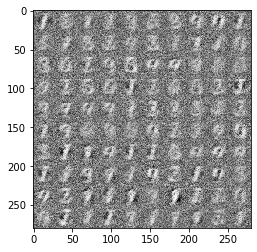

EPOCH 1 step 550: D: loss = 1.1294252 G: loss=0.9103837 
EPOCH 1 step 600: D: loss = 1.1338760 G: loss=0.9358592 
EPOCH 1 step 650: D: loss = 1.1162970 G: loss=0.9407138 
EPOCH 1 step 700: D: loss = 0.9958996 G: loss=0.9973885 
EPOCH 1 step 750: D: loss = 1.1135170 G: loss=0.9268326 
EPOCH 1 step 800: D: loss = 1.1032579 G: loss=0.9223044 
EPOCH 1 step 850: D: loss = 1.0627263 G: loss=0.9698745 
EPOCH 1 step 900: D: loss = 0.9966992 G: loss=0.9968893 
EPOCH 1 step 950: D: loss = 1.0532537 G: loss=0.9824530 
EPOCH 1 step 1000: D: loss = 0.9902338 G: loss=0.9838771 
EPOCH 1 step 1050: D: loss = 0.9761734 G: loss=1.0200598 


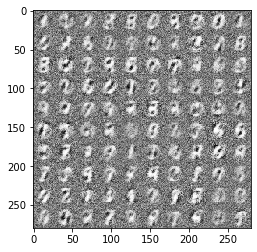

EPOCH 2 step 1100: D: loss = 0.9556982 G: loss=1.0764192 
EPOCH 2 step 1150: D: loss = 1.0172235 G: loss=0.9767646 
EPOCH 2 step 1200: D: loss = 0.9731872 G: loss=1.0196614 
EPOCH 2 step 1250: D: loss = 0.9678240 G: loss=1.0316637 
EPOCH 2 step 1300: D: loss = 0.9296930 G: loss=1.0688204 
EPOCH 2 step 1350: D: loss = 0.9007908 G: loss=1.0804697 
EPOCH 2 step 1400: D: loss = 0.8628024 G: loss=1.0451910 
EPOCH 2 step 1450: D: loss = 0.9115297 G: loss=1.0404466 
EPOCH 2 step 1500: D: loss = 0.9649302 G: loss=1.0406222 
EPOCH 2 step 1550: D: loss = 0.9628980 G: loss=1.0541053 
EPOCH 2 step 1600: D: loss = 0.8972770 G: loss=1.0407997 


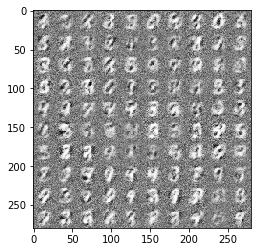

EPOCH 3 step 1650: D: loss = 0.8686534 G: loss=1.1267375 
EPOCH 3 step 1700: D: loss = 0.8986990 G: loss=1.0655216 
EPOCH 3 step 1750: D: loss = 0.8536120 G: loss=1.1273197 
EPOCH 3 step 1800: D: loss = 0.9589173 G: loss=1.0011768 
EPOCH 3 step 1850: D: loss = 0.9657574 G: loss=1.0334077 
EPOCH 3 step 1900: D: loss = 0.9941934 G: loss=0.9823619 
EPOCH 3 step 1950: D: loss = 0.9243650 G: loss=1.0237782 
EPOCH 3 step 2000: D: loss = 0.9663330 G: loss=1.0184352 
EPOCH 3 step 2050: D: loss = 1.0162321 G: loss=0.9632323 
EPOCH 3 step 2100: D: loss = 0.9669514 G: loss=0.9848229 
EPOCH 3 step 2150: D: loss = 1.0438682 G: loss=0.9908207 


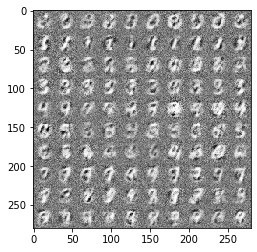

EPOCH 4 step 2200: D: loss = 1.0102766 G: loss=0.9751669 
EPOCH 4 step 2250: D: loss = 0.9786847 G: loss=0.9899327 
EPOCH 4 step 2300: D: loss = 1.0019782 G: loss=1.0241460 
EPOCH 4 step 2350: D: loss = 1.0143005 G: loss=0.9902164 
EPOCH 4 step 2400: D: loss = 1.0240144 G: loss=0.9462515 
EPOCH 4 step 2450: D: loss = 0.9999561 G: loss=1.0502812 
EPOCH 4 step 2500: D: loss = 1.0038357 G: loss=0.9732612 
EPOCH 4 step 2550: D: loss = 0.9908513 G: loss=1.0004396 
EPOCH 4 step 2600: D: loss = 0.9973772 G: loss=1.0111669 
EPOCH 4 step 2650: D: loss = 0.9849981 G: loss=1.0183222 
EPOCH 4 step 2700: D: loss = 0.9771844 G: loss=1.0085126 


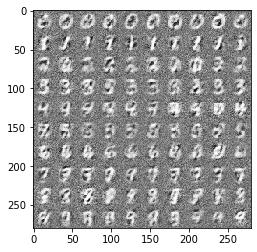

EPOCH 5 step 2750: D: loss = 1.0026288 G: loss=1.0106094 
EPOCH 5 step 2800: D: loss = 0.9915978 G: loss=1.0335451 
EPOCH 5 step 2850: D: loss = 0.9071247 G: loss=1.0694380 
EPOCH 5 step 2900: D: loss = 0.9670098 G: loss=1.0429450 
EPOCH 5 step 2950: D: loss = 0.8908260 G: loss=1.1129911 
EPOCH 5 step 3000: D: loss = 0.8934758 G: loss=1.1150018 
EPOCH 5 step 3050: D: loss = 0.9359423 G: loss=1.0975797 
EPOCH 5 step 3100: D: loss = 0.9003673 G: loss=1.0441127 
EPOCH 5 step 3150: D: loss = 0.8423607 G: loss=1.1786523 
EPOCH 5 step 3200: D: loss = 0.8763208 G: loss=1.1357412 
EPOCH 5 step 3250: D: loss = 0.8236574 G: loss=1.1846104 


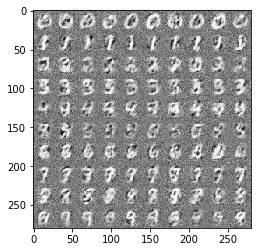

EPOCH 6 step 3300: D: loss = 0.9243435 G: loss=1.0952703 
EPOCH 6 step 3350: D: loss = 0.8984391 G: loss=1.0755348 
EPOCH 6 step 3400: D: loss = 0.7986265 G: loss=1.1763778 
EPOCH 6 step 3450: D: loss = 0.8423445 G: loss=1.1953356 
EPOCH 6 step 3500: D: loss = 0.7933690 G: loss=1.2215796 
EPOCH 6 step 3550: D: loss = 0.7521340 G: loss=1.2001843 
EPOCH 6 step 3600: D: loss = 0.7833437 G: loss=1.2557458 
EPOCH 6 step 3650: D: loss = 0.8047768 G: loss=1.2195585 
EPOCH 6 step 3700: D: loss = 0.7565513 G: loss=1.3333168 
EPOCH 6 step 3750: D: loss = 0.7612430 G: loss=1.3719099 
EPOCH 6 step 3800: D: loss = 0.6926348 G: loss=1.2711487 


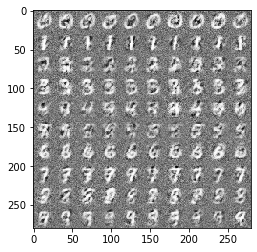

EPOCH 7 step 3850: D: loss = 0.7142416 G: loss=1.3266821 
EPOCH 7 step 3900: D: loss = 0.7377192 G: loss=1.2400475 
EPOCH 7 step 3950: D: loss = 0.6839124 G: loss=1.3382913 
EPOCH 7 step 4000: D: loss = 0.6625358 G: loss=1.5738777 
EPOCH 7 step 4050: D: loss = 0.7098264 G: loss=1.3989710 
EPOCH 7 step 4100: D: loss = 0.6494216 G: loss=1.3595415 
EPOCH 7 step 4150: D: loss = 0.6512007 G: loss=1.3416562 
EPOCH 7 step 4200: D: loss = 0.6918846 G: loss=1.4526902 
EPOCH 7 step 4250: D: loss = 0.5986422 G: loss=1.5710213 
EPOCH 7 step 4300: D: loss = 0.6285504 G: loss=1.4247923 
EPOCH 7 step 4350: D: loss = 0.6769204 G: loss=1.4162750 


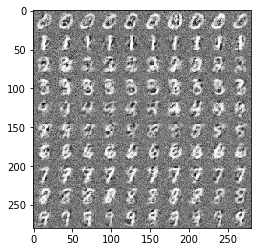

EPOCH 8 step 4400: D: loss = 0.7007275 G: loss=1.4188677 
EPOCH 8 step 4450: D: loss = 0.6596655 G: loss=1.4382991 
EPOCH 8 step 4500: D: loss = 0.5542238 G: loss=1.7106447 
EPOCH 8 step 4550: D: loss = 0.6274306 G: loss=1.4950110 
EPOCH 8 step 4600: D: loss = 0.6323575 G: loss=1.4998766 
EPOCH 8 step 4650: D: loss = 0.5408541 G: loss=1.6600428 
EPOCH 8 step 4700: D: loss = 0.5769042 G: loss=1.5266643 
EPOCH 8 step 4750: D: loss = 0.5550004 G: loss=1.6513869 
EPOCH 8 step 4800: D: loss = 0.6189338 G: loss=1.4959042 
EPOCH 8 step 4850: D: loss = 0.5901887 G: loss=1.4469675 
EPOCH 8 step 4900: D: loss = 0.5493990 G: loss=1.5498954 


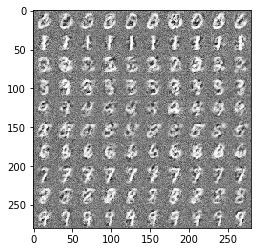

EPOCH 9 step 4950: D: loss = 0.5822327 G: loss=1.5329905 
EPOCH 9 step 5000: D: loss = 0.5106193 G: loss=1.6294835 
EPOCH 9 step 5050: D: loss = 0.5755997 G: loss=1.5641438 
EPOCH 9 step 5100: D: loss = 0.5551938 G: loss=1.5226538 
EPOCH 9 step 5150: D: loss = 0.6179368 G: loss=1.5442922 
EPOCH 9 step 5200: D: loss = 0.5290611 G: loss=1.6801811 
EPOCH 9 step 5250: D: loss = 0.5691158 G: loss=1.7996898 
EPOCH 9 step 5300: D: loss = 0.5502712 G: loss=1.7018509 
EPOCH 9 step 5350: D: loss = 0.5375926 G: loss=1.7223055 
EPOCH 9 step 5400: D: loss = 0.5449011 G: loss=1.6168325 
EPOCH 9 step 5450: D: loss = 0.5339671 G: loss=1.7126970 


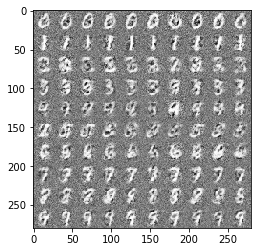

EPOCH 10 step 5500: D: loss = 0.5527351 G: loss=1.7153130 
EPOCH 10 step 5550: D: loss = 0.5455034 G: loss=1.6599196 
EPOCH 10 step 5600: D: loss = 0.5425349 G: loss=1.6739051 
EPOCH 10 step 5650: D: loss = 0.5663179 G: loss=1.5354506 
EPOCH 10 step 5700: D: loss = 0.5397372 G: loss=1.7460836 
EPOCH 10 step 5750: D: loss = 0.5398599 G: loss=1.4925448 
EPOCH 10 step 5800: D: loss = 0.5792701 G: loss=1.6346707 
EPOCH 10 step 5850: D: loss = 0.5584394 G: loss=1.6487765 
EPOCH 10 step 5900: D: loss = 0.5548820 G: loss=1.7086190 
EPOCH 10 step 5950: D: loss = 0.5422774 G: loss=1.6511912 
EPOCH 10 step 6000: D: loss = 0.4416003 G: loss=1.8990538 


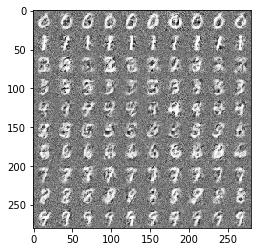

EPOCH 11 step 6050: D: loss = 0.5313156 G: loss=1.6103530 
EPOCH 11 step 6100: D: loss = 0.4570777 G: loss=1.8364964 
EPOCH 11 step 6150: D: loss = 0.5218944 G: loss=1.7077130 
EPOCH 11 step 6200: D: loss = 0.5480585 G: loss=1.7341037 
EPOCH 11 step 6250: D: loss = 0.5615008 G: loss=1.5657686 
EPOCH 11 step 6300: D: loss = 0.5642661 G: loss=1.5675058 
EPOCH 11 step 6350: D: loss = 0.4703653 G: loss=1.8183851 
EPOCH 11 step 6400: D: loss = 0.5644155 G: loss=1.5535418 
EPOCH 11 step 6450: D: loss = 0.5789717 G: loss=1.5816655 
EPOCH 11 step 6500: D: loss = 0.5353779 G: loss=1.7037902 
EPOCH 11 step 6550: D: loss = 0.5485861 G: loss=1.5881352 


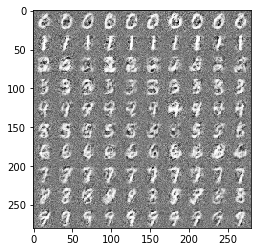

EPOCH 12 step 6600: D: loss = 0.5337392 G: loss=1.8055339 
EPOCH 12 step 6650: D: loss = 0.4899850 G: loss=1.8862325 
EPOCH 12 step 6700: D: loss = 0.5804191 G: loss=1.8269987 
EPOCH 12 step 6750: D: loss = 0.5598861 G: loss=1.7454309 
EPOCH 12 step 6800: D: loss = 0.5358130 G: loss=1.6361074 
EPOCH 12 step 6850: D: loss = 0.5504589 G: loss=1.5892169 
EPOCH 12 step 6900: D: loss = 0.5163062 G: loss=1.5475434 
EPOCH 12 step 6950: D: loss = 0.5018048 G: loss=1.7844898 
EPOCH 12 step 7000: D: loss = 0.4847915 G: loss=1.6601436 
EPOCH 12 step 7050: D: loss = 0.5384699 G: loss=1.5282302 


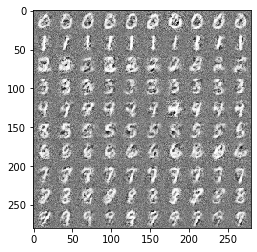

EPOCH 13 step 7100: D: loss = 0.4953996 G: loss=1.8106831 
EPOCH 13 step 7150: D: loss = 0.5962665 G: loss=1.5631102 
EPOCH 13 step 7200: D: loss = 0.5077416 G: loss=1.7911212 
EPOCH 13 step 7250: D: loss = 0.5129634 G: loss=1.8650588 
EPOCH 13 step 7300: D: loss = 0.4820198 G: loss=1.7036883 
EPOCH 13 step 7350: D: loss = 0.5490125 G: loss=1.7310505 
EPOCH 13 step 7400: D: loss = 0.5189015 G: loss=1.4886869 
EPOCH 13 step 7450: D: loss = 0.5176221 G: loss=1.6294893 
EPOCH 13 step 7500: D: loss = 0.5664777 G: loss=1.7332181 
EPOCH 13 step 7550: D: loss = 0.4922975 G: loss=1.7572064 
EPOCH 13 step 7600: D: loss = 0.4824827 G: loss=1.7769942 


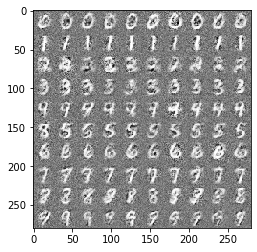

EPOCH 14 step 7650: D: loss = 0.4850017 G: loss=1.9296751 
EPOCH 14 step 7700: D: loss = 0.5379952 G: loss=1.7588109 
EPOCH 14 step 7750: D: loss = 0.4995666 G: loss=1.5320339 
EPOCH 14 step 7800: D: loss = 0.4936133 G: loss=1.8957605 
EPOCH 14 step 7850: D: loss = 0.5784150 G: loss=1.6260492 
EPOCH 14 step 7900: D: loss = 0.5267785 G: loss=1.6063277 
EPOCH 14 step 7950: D: loss = 0.4768768 G: loss=1.5883042 
EPOCH 14 step 8000: D: loss = 0.4591629 G: loss=1.8667212 
EPOCH 14 step 8050: D: loss = 0.4659203 G: loss=1.7106384 
EPOCH 14 step 8100: D: loss = 0.4870218 G: loss=1.7326790 
EPOCH 14 step 8150: D: loss = 0.4868141 G: loss=1.7743449 


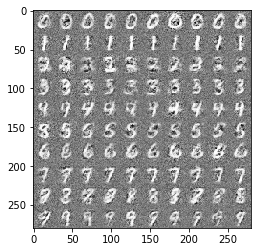

EPOCH 15 step 8200: D: loss = 0.4065458 G: loss=2.1690202 
EPOCH 15 step 8250: D: loss = 0.4795951 G: loss=1.6580386 
EPOCH 15 step 8300: D: loss = 0.5263647 G: loss=1.5432262 
EPOCH 15 step 8350: D: loss = 0.4571323 G: loss=1.8213110 
EPOCH 15 step 8400: D: loss = 0.4639643 G: loss=1.8149145 
EPOCH 15 step 8450: D: loss = 0.5030300 G: loss=1.8809166 
EPOCH 15 step 8500: D: loss = 0.4991383 G: loss=1.6186042 
EPOCH 15 step 8550: D: loss = 0.4725204 G: loss=1.8047535 
EPOCH 15 step 8600: D: loss = 0.5091695 G: loss=1.7789042 
EPOCH 15 step 8650: D: loss = 0.5192918 G: loss=2.0067737 
EPOCH 15 step 8700: D: loss = 0.4834721 G: loss=1.9147317 


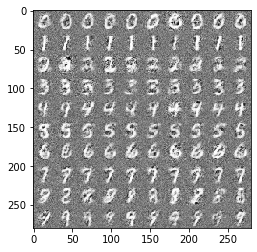

EPOCH 16 step 8750: D: loss = 0.4320489 G: loss=1.6884973 
EPOCH 16 step 8800: D: loss = 0.4745681 G: loss=1.6758586 
EPOCH 16 step 8850: D: loss = 0.4614782 G: loss=1.8229492 
EPOCH 16 step 8900: D: loss = 0.5147284 G: loss=1.5215846 
EPOCH 16 step 8950: D: loss = 0.5185158 G: loss=1.9210484 
EPOCH 16 step 9000: D: loss = 0.4806120 G: loss=2.1339204 
EPOCH 16 step 9050: D: loss = 0.4135262 G: loss=2.1723113 
EPOCH 16 step 9100: D: loss = 0.5354408 G: loss=1.4760731 
EPOCH 16 step 9150: D: loss = 0.4753757 G: loss=1.9104676 
EPOCH 16 step 9200: D: loss = 0.4545541 G: loss=1.9927537 
EPOCH 16 step 9250: D: loss = 0.4840612 G: loss=1.9099253 


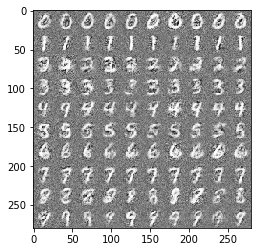

EPOCH 17 step 9300: D: loss = 0.5148548 G: loss=2.1274157 
EPOCH 17 step 9350: D: loss = 0.4380160 G: loss=1.9528366 
EPOCH 17 step 9400: D: loss = 0.4582922 G: loss=1.9009418 
EPOCH 17 step 9450: D: loss = 0.4707461 G: loss=1.7380174 
EPOCH 17 step 9500: D: loss = 0.4801337 G: loss=1.6895925 
EPOCH 17 step 9550: D: loss = 0.4960701 G: loss=1.8038602 
EPOCH 17 step 9600: D: loss = 0.5052696 G: loss=1.8216743 
EPOCH 17 step 9650: D: loss = 0.4507710 G: loss=1.8068138 
EPOCH 17 step 9700: D: loss = 0.4253452 G: loss=1.7434632 
EPOCH 17 step 9750: D: loss = 0.4785413 G: loss=1.7310792 
EPOCH 17 step 9800: D: loss = 0.4575602 G: loss=1.9315760 


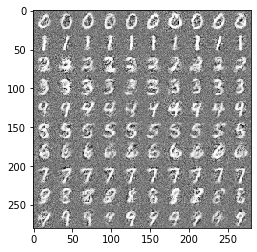

EPOCH 18 step 9850: D: loss = 0.4355274 G: loss=2.0880270 
EPOCH 18 step 9900: D: loss = 0.4152642 G: loss=1.8032708 
EPOCH 18 step 9950: D: loss = 0.4667318 G: loss=1.9419047 
EPOCH 18 step 10000: D: loss = 0.5004566 G: loss=1.6399776 
EPOCH 18 step 10050: D: loss = 0.4510416 G: loss=2.1187797 
EPOCH 18 step 10100: D: loss = 0.4576441 G: loss=2.1949792 
EPOCH 18 step 10150: D: loss = 0.4967693 G: loss=1.6220444 
EPOCH 18 step 10200: D: loss = 0.4814595 G: loss=1.7725179 
EPOCH 18 step 10250: D: loss = 0.5035349 G: loss=1.9253350 
EPOCH 18 step 10300: D: loss = 0.4935967 G: loss=1.9741843 
EPOCH 18 step 10350: D: loss = 0.4765707 G: loss=1.8093522 


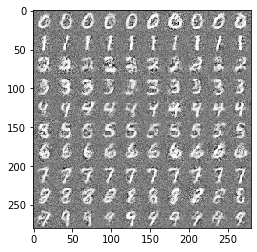

EPOCH 19 step 10400: D: loss = 0.4537363 G: loss=1.7793367 
EPOCH 19 step 10450: D: loss = 0.4777355 G: loss=1.8457189 
EPOCH 19 step 10500: D: loss = 0.4522674 G: loss=1.9218322 
EPOCH 19 step 10550: D: loss = 0.4545705 G: loss=1.8540034 
EPOCH 19 step 10600: D: loss = 0.4915876 G: loss=1.9510232 
EPOCH 19 step 10650: D: loss = 0.4698810 G: loss=1.8102568 
EPOCH 19 step 10700: D: loss = 0.4686756 G: loss=1.9307446 
EPOCH 19 step 10750: D: loss = 0.6433861 G: loss=1.1079849 
EPOCH 19 step 10800: D: loss = 0.4510956 G: loss=1.6565546 
EPOCH 19 step 10850: D: loss = 0.3988168 G: loss=2.0258677 
EPOCH 19 step 10900: D: loss = 0.4146826 G: loss=2.1541839 


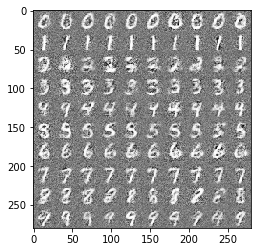

EPOCH 20 step 10950: D: loss = 0.4390371 G: loss=1.8838696 
EPOCH 20 step 11000: D: loss = 0.4214670 G: loss=1.9509568 
EPOCH 20 step 11050: D: loss = 0.4850332 G: loss=1.6265125 
EPOCH 20 step 11100: D: loss = 0.4417650 G: loss=2.0168684 
EPOCH 20 step 11150: D: loss = 0.4467051 G: loss=1.8717598 
EPOCH 20 step 11200: D: loss = 0.4362225 G: loss=1.9300908 
EPOCH 20 step 11250: D: loss = 0.4159848 G: loss=1.9012978 
EPOCH 20 step 11300: D: loss = 0.4130325 G: loss=2.1716475 
EPOCH 20 step 11350: D: loss = 0.4026532 G: loss=2.0451500 
EPOCH 20 step 11400: D: loss = 0.4958150 G: loss=1.8091190 
EPOCH 20 step 11450: D: loss = 0.4712908 G: loss=1.7290319 


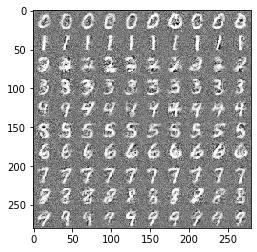

In [12]:
sample_z = np.random.uniform(-1 , 1 , size = [batch_size , sample_size])

y = tf.placeholder(tf.float32, [None , y_dim])

images = tf.placeholder(tf.float32, [batch_size, output_size, output_size, channel])

z = tf.placeholder(tf.float32, [None , sample_size])

fake_images = gern_net(batch_size, z , y ,sample_size, y_dim,output_size)

##the loss of gerenate network
D_pro , D_logits = dis_net(images, y ,  False)

G_pro, G_logits = dis_net(fake_images , y , True)

#### TODO ####
# DEFINE LOSS FUNCTION #

D_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logits, labels=tf.ones_like(D_logits)))
D_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=G_logits, labels=tf.zeros_like(G_logits)))
D_loss = D_loss_real + D_loss_fake
G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=G_logits, labels=tf.ones_like(G_logits)))

#############

t_vars = tf.trainable_variables()

d_var = [var for var in t_vars if 'dis' in var.name]
g_var = [var for var in t_vars if 'gen' in var.name]

opti_D = tf.train.AdamOptimizer(learning_rate=learning_rate , beta1=0.5).minimize(D_loss , var_list=d_var)
opti_G = tf.train.AdamOptimizer(learning_rate=learning_rate , beta1=0.5).minimize(G_loss , var_list=g_var)

init = tf.global_variables_initializer()
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

with tf.Session(config=config) as sess:

    sess.run(init)
    e = 0
    step = 0

    while e <= EPOCH:
        batch_num = 0
        while batch_num < len(data_array) / batch_size - 1:

            step = step + 1

            realbatch_array , real_labels = getNext_batch(data_array , data_y , batch_num, batch_size)
            
            #Get the z
            batch_z = np.random.uniform(-1 , 1 , size=[batch_size , sample_size])

            _ = sess.run(opti_D, feed_dict={images:realbatch_array, z:batch_z , y:real_labels})
            _ = sess.run(opti_G, feed_dict={z: batch_z , y:real_labels})

            batch_num += 1

            if step % loss_step == 0:

                d_get_loss = sess.run(D_loss , feed_dict = {images:realbatch_array , z:batch_z , y:real_labels})
                g_get_loss = sess.run(G_loss , feed_dict = {z: batch_z , y:real_labels})
                print("EPOCH %d step %d: D: loss = %.7f G: loss=%.7f " % (e , step , d_get_loss , g_get_loss))

            if np.mod(step , display_step) == 1:

                sample_images = sess.run(fake_images , feed_dict={z:sample_z , y:sample_label(batch_size)})
                sample_images = sample_images[:100,:,:,:]
                image_name = './{}/train_{:02d}_{:04d}.png'.format(sample_dir , e , step)
                save_images(sample_images , [10,10] , image_name)

        img = mpimg.imread(image_name)
        imgplot = plt.imshow(img)
        plt.show()

        e = e + 1
        batch_num = 0
